In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import matplotlib as mpl

mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

mpl.rcParams["font.family"] = "Arial"

In [212]:
import matplotlib.font_manager as font_manager

fm = font_manager.FontManager()
fm.get_font_names()

['DejaVu Serif',
 'STIXSizeOneSym',
 'Liberation Sans Narrow',
 'Arial',
 'cmb10',
 'cmr10',
 'DejaVu Serif Display',
 'DejaVu Sans',
 'STIXNonUnicode',
 'cmex10',
 'Liberation Sans',
 'STIXGeneral',
 'cmmi10',
 'DejaVu Sans Display',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'STIXSizeFourSym',
 'STIXSizeFiveSym',
 'cmtt10',
 'cmsy10',
 'cmss10',
 'Liberation Serif',
 'STIXSizeThreeSym',
 'Liberation Mono']

In [213]:
font_manager.findfont("Arial")

'/opt/conda/envs/patch/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf'

 # Patch clamp analysis

In [214]:
import matplotlib.pyplot as plt

from patch_clamp_functions import *

 ## sEPSC demo trace

In [215]:
sEPSCparser = epsc_parser()
print(len(sEPSCparser.files["abf"]))

95


 ### representative trace

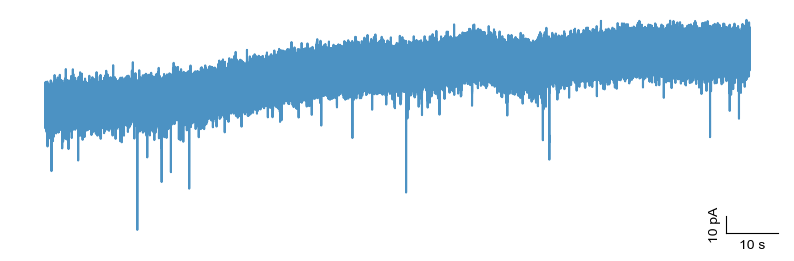

In [216]:
sEPSCparser.plot_demo_epsc(79)

 ## cumulative distribution

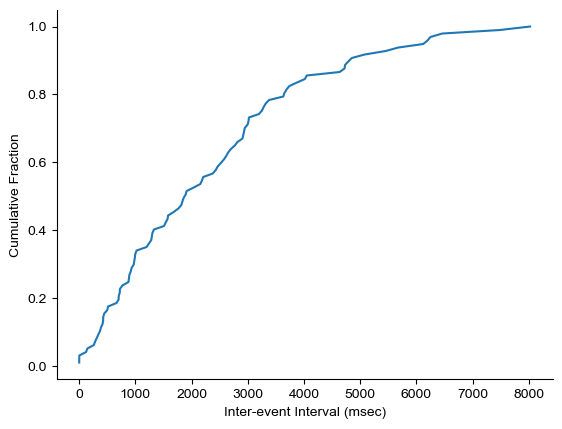

In [217]:
itiDemoData = sEPSCparser.read_demo_stat_data("iti", 0)

plt.plot(itiDemoData["Inter-event Interval (msec)"], itiDemoData["Cumulative Fraction"])
plt.xlabel("Inter-event Interval (msec)")
plt.ylabel("Cumulative Fraction")
plt.show()

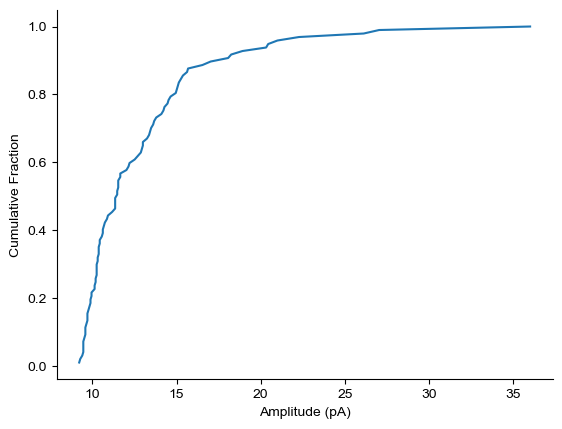

In [218]:
ampDemoData = sEPSCparser.read_demo_stat_data("amp", 0)
plt.plot(ampDemoData["Amplitude (pA)"], ampDemoData["Cumulative Fraction"])
plt.xlabel("Amplitude (pA)")
plt.ylabel("Cumulative Fraction")
plt.savefig('figures/png/cumulative_sEPSP_amplitute',dpi=600)
plt.show()

 ## AP demo trace

 ### raw trace

In [219]:
ap_ps = ap_parser()
print(len(ap_ps.files["abf"]))

115


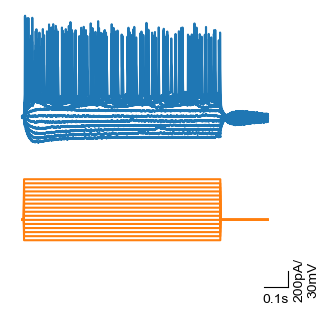

In [220]:
ap_ps.plot_demo_ap(82, sweepYcolor="C0", sweepCcolor="C1")

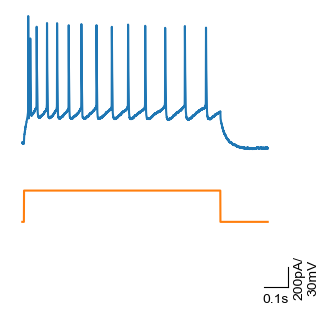

In [221]:
ap_ps.plot_demo_ap(54, sweep=12, sweepYcolor="C0", sweepCcolor="C1")

 ### AP distribution

In [222]:
fitDemoData = ap_ps.read_demo_fit_stat(0)
fitDemoData.head()

,filename,sweep,AP_ID,Amplitude,Time,Baseline,Rise,Area,Half-width,Burst#,...,Peak,Peak2AH,Threshold,Width,AHP Area,Decay%,col_17,col_18,col_19,col_20
0,19408008.abf,7,1,58.411,18146.6,-20.691,4.0,1154.858,24.2,0.0,...,0.0,25.6,-4.456,20.086,-12.109,-7.019,20.6,0,0,0
1,19408008.abf,7,2,53.711,18295.8,-14.038,4.0,869.775,19.4,0.0,...,0.0,23.8,-0.122,13.803,-65.881,-14.893,18.4,0,0,0
2,19408008.abf,7,3,54.321,18434.8,-14.893,4.2,863.049,19.4,0.0,...,0.0,22.6,4.883,7.357,-77.515,-14.099,17.6,0,0,0
3,19408008.abf,7,4,53.650,18571.6,-14.343,4.8,822.144,18.2,0.0,...,0.0,21.8,5.249,7.048,-93.408,-14.771,16.6,0,0,0
4,19408008.abf,7,5,50.110,18720.8,-12.207,4.0,750.476,17.8,0.0,...,0.0,21.0,12.207,2.971,-120.606,-16.724,15.4,0,0,0


In [223]:
EvDemoData = ap_ps.read_demo_event_stat(0)
EvDemoData.head()

,Time (ms),Amplitude,Rise (ms),Decay (ms),Area,Baseline,Noise,Group,Channel,10-90Rise,HalfWidth,Rise50,Peak Dir,Burst#,BurstE#,10-90Slope,Rel Time\n,Identifier
0,24149.6,107.666,3.4,0.8,106.48,-31.494,-0.122,9,0,0.33,0.87,0.4,1,0,0,259.14,188.0,12d30003
1,24284.8,105.591,1.2,0.8,109.79,-29.541,0.488,9,0,0.32,0.96,0.6,1,0,0,267.96,16.0,12d30003
2,24455.2,103.638,2.0,0.8,111.84,-29.602,0.122,9,0,0.36,0.97,0.6,1,0,0,228.00,186.4,12d30003
3,24609.0,107.361,2.6,0.8,115.15,-30.884,-0.183,9,0,0.34,0.97,0.6,1,0,0,255.24,33.0,12d30003
4,24857.4,106.506,1.2,0.8,108.54,-29.297,0.244,9,0,0.33,0.95,0.6,1,0,0,256.29,281.4,12d30003


In [224]:
IFdemoData = ap_ps.get_demo_IF_data(0)
IFallData = ap_ps.get_all_data("IF")

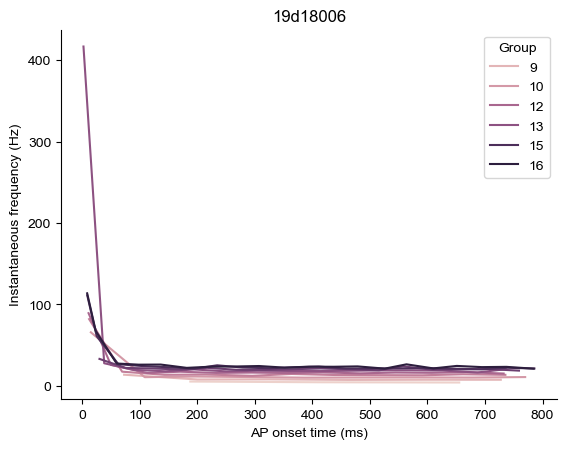

In [225]:
ap_ps.plot_demo_IF(4)

In [226]:
IFstat = get_CV_of_IF(IFallData)

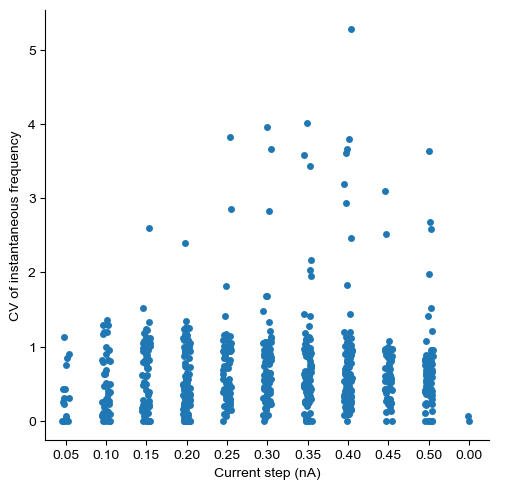

In [227]:
plot_IF_CV_distribution(IFstat)

 ### AP frequency

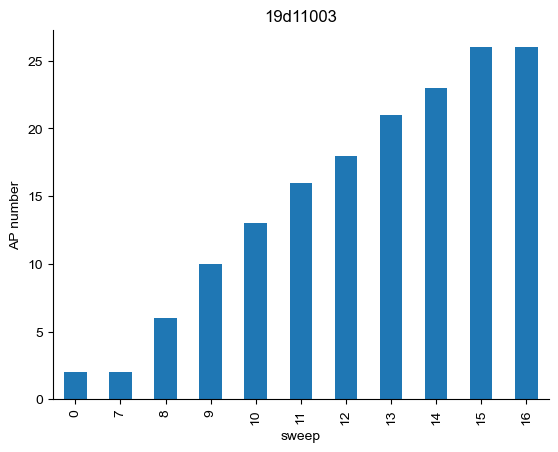

In [228]:
ap_ps.plot_demo_distribution("freq", 0)

In [229]:
apAllFreqData = ap_ps.get_all_data("freq")

 ### AP amplitude

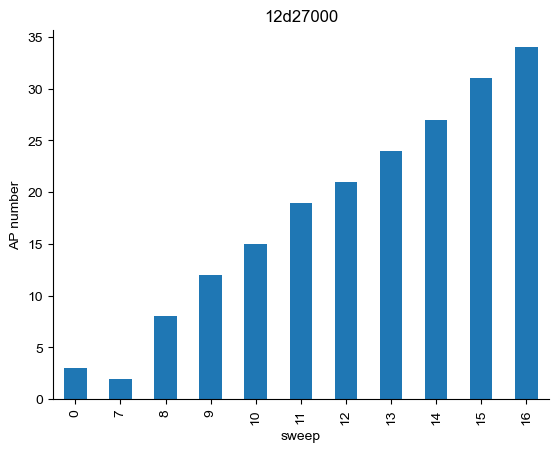

In [230]:
ap_ps.plot_demo_distribution("amp", 12)

 ## time constant (tau)

 Read tau results

In [231]:
tauData = ap_ps.get_all_data("tau")
tauData.head()

,File Name,CellID,Signal,Trace,Trace Start (ms),Fit Function,Best Number of Terms,A,S.E.,tau,...,Cursor 3 Intercept,Cursor 4 Intercept,Correlation Coefficient,Standard Deviation,Sum of Squared Errors,Sum of Data Squared,Points Fitted,Fitted Area,Results,File Path
0,20109000.abf,20109000,IN 0,1,0,"Exponential, standard, 1st Order",N/A,3.61296,0.26061,28.0279,...,N/A,N/A,0.9735,1.55238,1927.9,2.74532e+006,801,9363.28,Successful fit.,F:\Fan Zuquan\AP\20200109\cell1\
1,20109000.abf,20109000,IN 0,2,5000,"Exponential, standard, 1st Order",N/A,1.17747,1.42209,153.2850,...,N/A,N/A,0.969796,1.74628,2439.6,2.67415e+006,801,9240.42,Successful fit.,F:\Fan Zuquan\AP\20200109\cell1\
2,20109000.abf,20109000,IN 0,3,10000,"Exponential, standard, 1st Order",N/A,3.26768,0.271451,23.7344,...,N/A,N/A,0.974661,1.49082,1778.04,2.76928e+006,801,9403.75,Successful fit.,F:\Fan Zuquan\AP\20200109\cell1\
3,20109000.abf,20109000,IN 0,4,15000,"Exponential, standard, 1st Order",N/A,3.02185,0.265009,23.6505,...,N/A,N/A,0.975408,1.45292,1688.78,2.79248e+006,801,9443.91,Successful fit.,F:\Fan Zuquan\AP\20200109\cell1\
4,20109000.abf,20109000,IN 0,5,20000,"Exponential, standard, 1st Order",N/A,2.10832,0.243805,28.8832,...,N/A,N/A,0.975302,1.47357,1737.12,2.84775e+006,801,9536.99,Successful fit.,F:\Fan Zuquan\AP\20200109\cell1\


### filter outlier

In [232]:
ap_ps.is_outlier().head()

/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:393: FutureWarning: The provided callable <function mean at 0xffffb019e480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({"tau": np.mean, "C": variation})


,CellID,tau,C,isOutlier
0,,50.067900,-0.000000,False
1,12d27000,2.544888,-0.037321,False
2,12d27007,65.885063,-0.015410,False
3,12d30000,35.837413,-0.005889,False
4,12d30003,-120.654656,-0.052336,True


### time constant statistic

/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:393: FutureWarning: The provided callable <function mean at 0xffffb019e480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({"tau": np.mean, "C": variation})


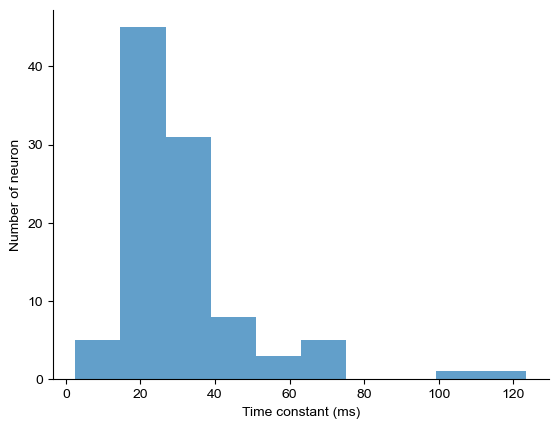

In [233]:
ap_ps.plot_tau_distribution()

 ## I/V relationship

 ### plot I-V traces

In [234]:
ivAllData = ap_ps.get_all_data("iv")
ivAllData.head()

,File Name,CellID,Trace,Trace Start (ms),Signal 1,Region 1,Start Time R1 (ms),End Time R1 (ms),Vm,File Path,I
0,19408008.abf,19408008,1,0,Cur_Clamp,Cursors 3..4,577,885.8,-85.5854,E:\data\patch\AP\20190408\cell 1\,-0.20
1,19408008.abf,19408008,2,5000,Cur_Clamp,Cursors 3..4,577,885.8,-77.3404,E:\data\patch\AP\20190408\cell 1\,-0.15
2,19408008.abf,19408008,3,10000,Cur_Clamp,Cursors 3..4,577,885.8,-68.9896,E:\data\patch\AP\20190408\cell 1\,-0.10
3,19408008.abf,19408008,4,15000,Cur_Clamp,Cursors 3..4,577,885.8,-59.7691,E:\data\patch\AP\20190408\cell 1\,-0.05
4,19408008.abf,19408008,5,20000,Cur_Clamp,Cursors 3..4,577,885.8,-46.6174,E:\data\patch\AP\20190408\cell 1\,0.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


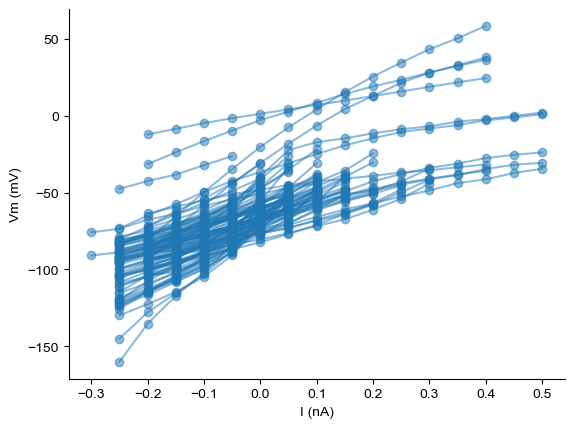

In [235]:
plot_iv_traces(ivAllData, to_save="IV_trace")

 ### Compute membrane resistance

In [236]:
RmRes = compute_Rm(ivAllData)
RmRes.head()

,CellID,Rm,R_score
0,12d27000,144.654055,0.990183
1,12d30003,130.907212,0.976966
2,19408000,240.104054,0.988642
3,19408008,214.399711,0.979738
4,19417000,273.753396,0.988567


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


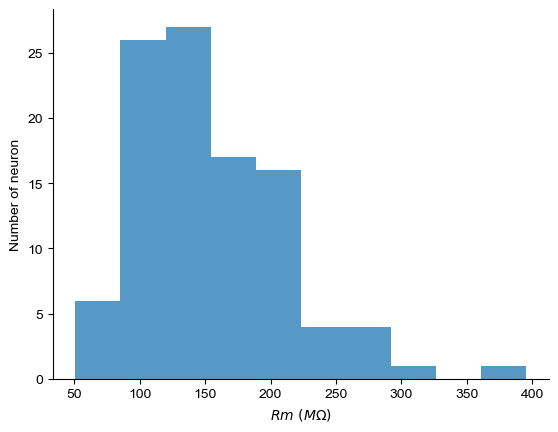

In [237]:
plot_Rm_distribution(RmRes, to_save="Rm_hist")

 ## ramp current triggered voltage

In [238]:
ramp_ps = ramp_parser()

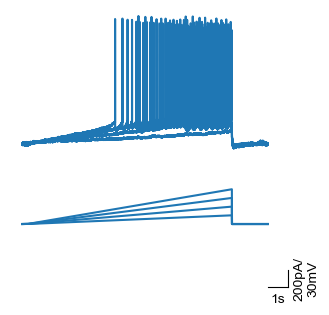

In [239]:
ramp_ps.plot_demo_ramp(20)

 # Morphological analysis

In [240]:
import morphio

In [241]:
morphio.set_maximum_warnings(0)

In [242]:
from morphological_functions import morpho_parser

mpp = morpho_parser()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


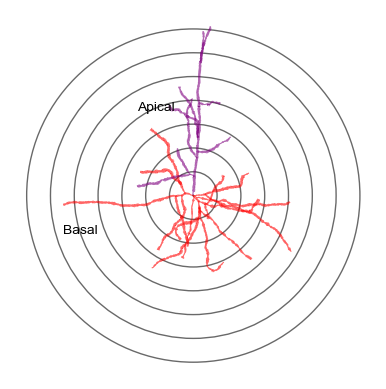

In [243]:
from morphological_functions import plot_sholl_demo

plot_sholl_demo(mpp.neurons[7], to_save='Sholl_demo')

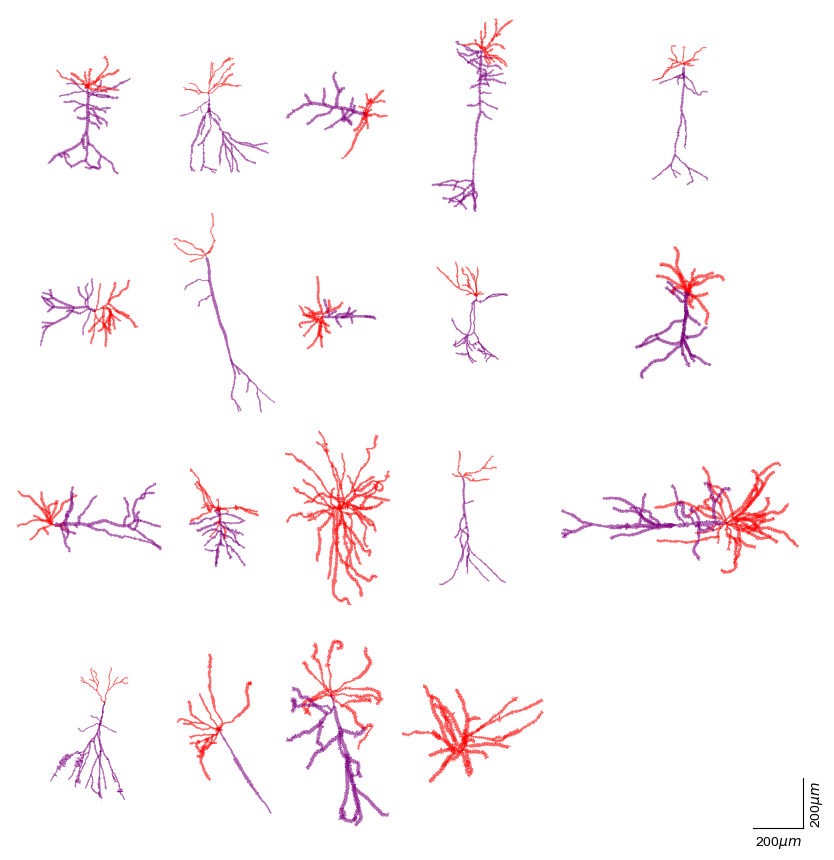

In [244]:
mpp.plot_all_neurons()

 Put apical dendrites upside:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/memory_fzq/work/patch/analysis/20191107/morphological_functions.py:127: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Radius ($\mu m$)")
/home/memory_fzq/work/patch/analysis/20191107/morphological_functions.py:161: SyntaxWarning: invalid escape sequence '\ '
  plt.xlabel("$Radius\ (\mu m)$")
/home/memory_fzq/work/patch/analysis/20191107/morphological_functions.py:355: SyntaxWarning: invalid escape sequence '\m'
  def plot_multi_neuron(neurons, layout, to_save="", scalebar=(200,"$\mu m$"),fig_size=None):


KeyboardInterrupt: 

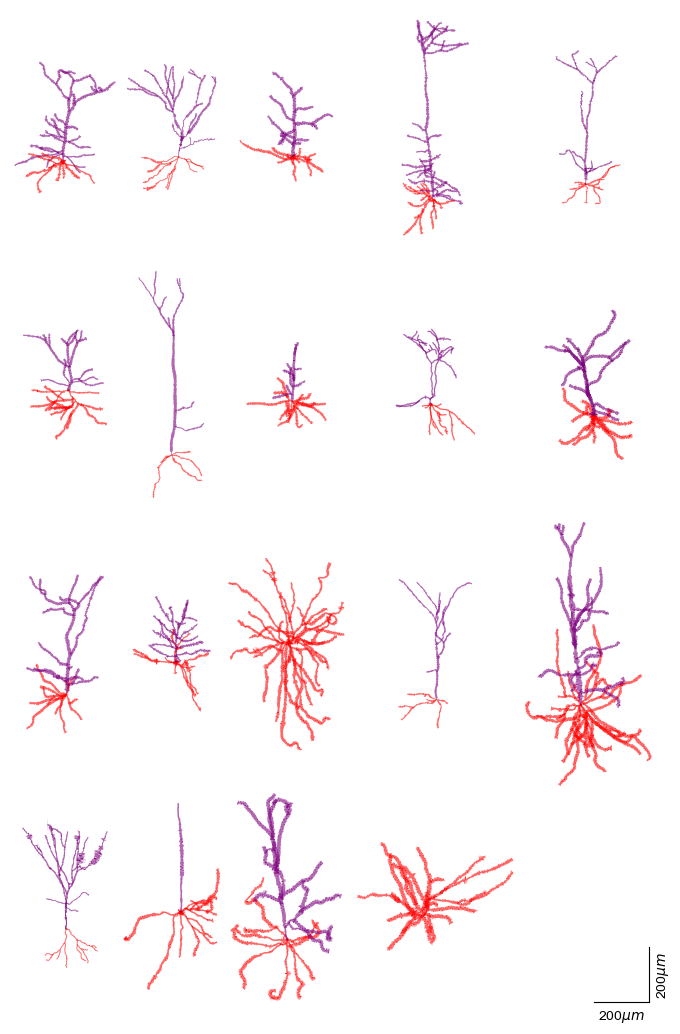

In [245]:
mpp.plot_apical_upside(to_save='all neurons')

 ## Sholl analysis

 Analyse by neurom:

In [ ]:
shollParts = mpp.sholl_part_data  # time consuming
shollParts.head()

,radius,intersections,label,id
1,1,1.0,apical,20190620_neuron3.swc
2,2,1.0,apical,20190620_neuron3.swc
3,3,1.0,apical,20190620_neuron3.swc
4,4,1.0,apical,20190620_neuron3.swc
5,5,1.0,apical,20190620_neuron3.swc


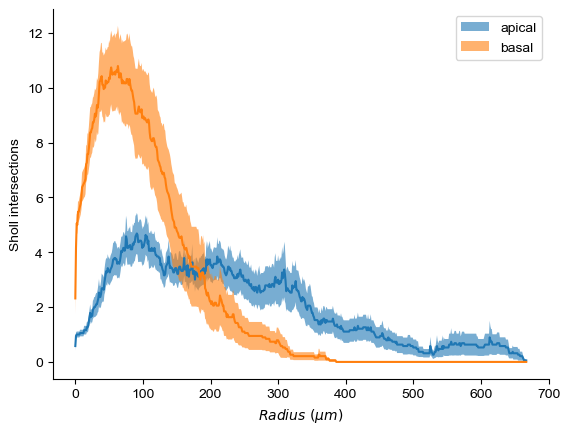

In [ ]:
mpp.plot_sholl(sholl_part=True)

 Analyse by morphological data exported by Imaris:

In [ ]:
morphoData = mpp.imarisData
morphoData.head()

,Category,Collection,Default Labels,Dendrite Area,Depth,Distance,FilamentID,ID,Level,Radius,Time,Type,Unit,Unnamed: 14,Unnamed: 9,Value,Variable,neuron_ID
0,Dendrite,NaN,basal,NaN,1.0,NaN,100000000.0,510000000001,1.0,NaN,1,NaN,um^2,NaN,NaN,41.5376,Dendrite Area,20190620_neuron3
1,Dendrite,NaN,basal,NaN,2.0,NaN,100000000.0,510000000067,2.0,NaN,1,NaN,um^2,NaN,NaN,14.9117,Dendrite Area,20190620_neuron3
2,Dendrite,NaN,basal,NaN,3.0,NaN,100000000.0,510000000090,2.0,NaN,1,NaN,um^2,NaN,NaN,122.4580,Dendrite Area,20190620_neuron3
3,Dendrite,NaN,basal,NaN,3.0,NaN,100000000.0,510000000346,3.0,NaN,1,NaN,um^2,NaN,NaN,107.6860,Dendrite Area,20190620_neuron3
4,Dendrite,NaN,basal,NaN,2.0,NaN,100000000.0,510000000567,1.0,NaN,1,NaN,um^2,NaN,NaN,131.9460,Dendrite Area,20190620_neuron3


/home/memory_fzq/work/patch/analysis/20191107/morphological_functions.py:116: FutureWarning: The provided callable <function mean at 0xffffb019e480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg([np.mean, sem])


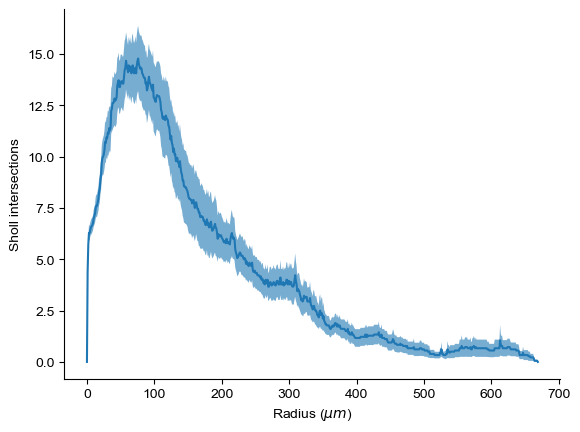

In [ ]:
mpp.plot_sholl(sholl_part=False)

 ## angle distribution

 ## branch order

In [ ]:
depthData = mpp.depthData
depthData.head()

,neuron_ID,Depth,counts
0,20190620_neuron3,1,4
1,20190620_neuron3,2,6
2,20190620_neuron3,3,10
3,20190620_neuron3,4,11
4,20190620_neuron3,5,8


/home/memory_fzq/work/patch/analysis/20191107/morphological_functions.py:195: FutureWarning: The provided callable <function mean at 0xffffb019e480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  depthPlotData = depthData.groupby("Depth")[["counts"]].agg([np.mean, sem]).reset_index()
/opt/conda/envs/patch/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/patch/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


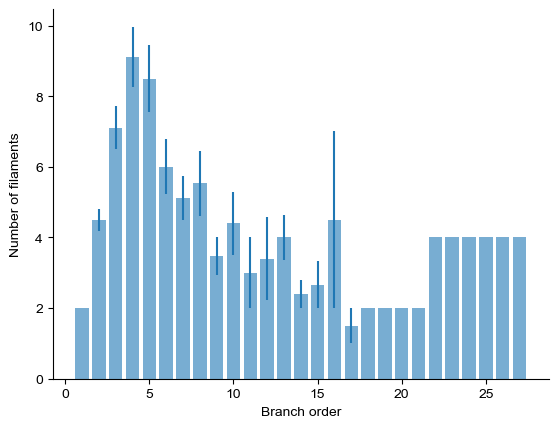

In [ ]:
mpp.plot_depth()

 # Cluster Analysis

 ## Electrophysiological Parameters

 Get all electrophysiological data

In [ ]:
elec_ps = electro_parser()
electroParaData_py = elec_ps.get_all_data()  # time consuming
electroParaData_py.head()

featureName,CellID,trace,AP1_amp,AP2_amp,APlast_amp,ISI_log_slope,ISI_semilog_slope,inv_first_ISI,inv_last_ISI,inv_second_ISI,inv_third_ISI,inv_time_to_first_spike,mean_AHP_depth_abs,mean_AHP_depth_abs_slow,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike
0,12d27000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.293304,NaN
1,12d27000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.013916,NaN
2,12d27000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.152687,NaN
3,12d27000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.859940,NaN
4,12d27000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.910873,NaN


In [ ]:
electroParaData_loc = elec_ps.get_all_data(method="local")
electroParaData_loc.head()

,CellID,Rm,RMP,tau,isOutlier,n,Freq (Hz),CV_of_IF
0,,NaN,NaN,50.067900,False,NaN,NaN,NaN
1,12d27000,144.654055,-57.2191,2.544888,False,24.0,31.546,0.266226
2,12d27007,NaN,NaN,65.885063,False,22.0,29.506,NaN
3,12d30000,NaN,NaN,35.837413,False,17.0,21.823,NaN
4,12d30003,130.907212,-57.6961,-120.654656,True,21.0,26.656,0.462496


In [ ]:
electroParaData = elec_ps.get_all_data(method="all")
electroParaData.head()

,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,ramp_slope,threshold_I,threshold_V,ramp_spiking_time
0,12d27000,20191227,1,12d27003,12d27002,144.654055,-57.2191,2.544888,False,24.0,...,2.616000,1.028000,2.108000,4.0,-39.351349,800.2,0.02,0.061041,-31.494141,3.2994
1,NaN,20191227,2,12d27009,12d27008,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.107726,-10.986328,5.6336
2,NaN,20191230,1,12d30002,12d30001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.189916,-21.667480,9.7430
3,12d30003,20191230,2,12d30005,12d30004,130.907212,-57.6961,-120.654656,True,21.0,...,2.304762,0.890476,2.142857,4.0,-26.006165,791.8,0.02,0.125143,-25.085449,6.5044
4,19807000,20190807,1,19807003,19807002,84.933704,-67.4206,17.244736,False,NaN,...,2.400000,0.900000,1.800000,1.0,-38.331871,9.2,NaN,NaN,NaN,NaN


## Morphological Parameters

In [ ]:
morphoData = mpp.get_all_data()  # time consuming
morphoData.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_leaves,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal)
0,20190620_neuron3,10910.00,10910.00,4083.05,2821.49,305.977,8.0,6.0,4083.05,26.0,...,31.0,4.0,57.0,10687.0,4081.369858,2834.939976,1246.429882,2821.164532,2287.254572,533.909960
1,20190621_neuron5,11333.90,11333.90,4358.37,3911.53,342.625,13.0,6.0,4358.37,46.0,...,50.0,4.0,96.0,10620.0,4357.301262,3468.067425,889.233837,3910.565760,3719.070310,191.495450
2,20190630_neuron1,6855.76,6855.76,2014.88,2291.71,446.037,7.0,3.0,2014.88,7.0,...,13.0,6.0,20.0,2518.0,2007.632324,1376.187553,631.444771,2290.291278,1962.327718,327.963560
3,20190630_neuron2,7529.28,7529.28,2988.55,1775.40,425.158,9.0,5.0,2988.55,28.0,...,33.0,6.0,60.0,11625.0,2987.019941,2070.660289,916.359652,1775.096559,1357.492065,417.604493
4,20190701_neuron4,6091.93,6091.93,2058.37,1589.63,327.495,9.0,3.0,2058.37,18.0,...,21.0,5.0,37.0,2040.0,2053.981322,1499.087242,554.894080,1588.768071,1214.119188,374.648883


 ## analysis

In [ ]:
from neuron_cluster_analysis import cluster_processor

analysor = cluster_processor(elec_ps, mpp)
cluster_data = analysor.get_all_data("inner")
cluster_data.head()

,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,number_of_leaves,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal)
0,19612002,20190612,4,NaN,NaN,126.673046,-65.7994,26.651977,False,4.0,...,31.0,4.0,57.0,10687.0,4081.369858,2834.939976,1246.429882,2821.164532,2287.254572,533.909960
1,19612003,20190612,5,NaN,NaN,97.830327,-67.4632,36.350580,False,NaN,...,50.0,4.0,96.0,10620.0,4357.301262,3468.067425,889.233837,3910.565760,3719.070310,191.495450
2,19626000,20190626,1,19626001,NaN,133.875355,-71.0943,25.419869,False,10.0,...,13.0,6.0,20.0,2518.0,2007.632324,1376.187553,631.444771,2290.291278,1962.327718,327.963560
3,19626002,20190626,2,NaN,NaN,127.392784,-72.7821,24.653300,False,6.0,...,33.0,6.0,60.0,11625.0,2987.019941,2070.660289,916.359652,1775.096559,1357.492065,417.604493
4,19626005,20190626,4,NaN,NaN,158.948569,-74.6864,20.567454,False,20.0,...,21.0,5.0,37.0,2040.0,2053.981322,1499.087242,554.894080,1588.768071,1214.119188,374.648883


 ### K-Means

Analyze electrophysiological data and morphological data:

In [ ]:
km = analysor.k_means()
km.head()

,cellID_ap,Rm,RMP,tau,n,Freq (Hz),CV_of_IF,AP1_amp,AP2_amp,APlast_amp,...,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal),cluster
0,19612002,126.673046,-65.7994,26.651977,4.0,18.100,0.462213,NaN,NaN,NaN,...,4.0,57.0,10687.0,4081.369858,2834.939976,1246.429882,2821.164532,2287.254572,533.909960,0
1,19612003,97.830327,-67.4632,36.350580,NaN,NaN,NaN,118.225098,NaN,118.225098,...,4.0,96.0,10620.0,4357.301262,3468.067425,889.233837,3910.565760,3719.070310,191.495450,0
2,19626000,133.875355,-71.0943,25.419869,10.0,14.160,1.088870,135.620117,112.365723,106.079102,...,6.0,20.0,2518.0,2007.632324,1376.187553,631.444771,2290.291278,1962.327718,327.963560,0
3,19626002,127.392784,-72.7821,24.653300,6.0,10.909,1.409690,116.516113,65.917969,75.927734,...,6.0,60.0,11625.0,2987.019941,2070.660289,916.359652,1775.096559,1357.492065,417.604493,0
4,19626005,158.948569,-74.6864,20.567454,20.0,26.518,0.586973,134.338379,73.486328,113.342285,...,5.0,37.0,2040.0,2053.981322,1499.087242,554.894080,1588.768071,1214.119188,374.648883,0


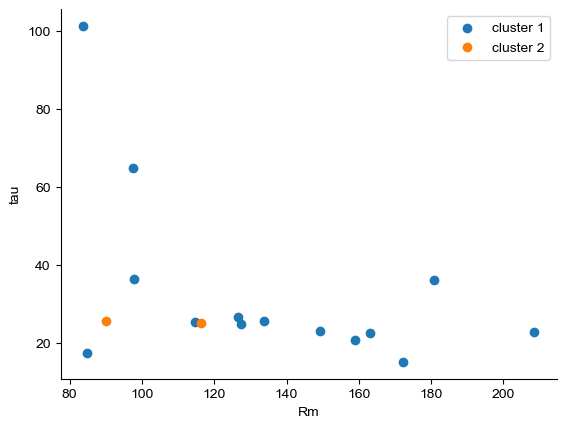

In [ ]:
analysor.plot_cluster_scatter("Rm", "tau")

Not well.

Only analyze electrophysiological data:

In [291]:
cluster_data_e = analysor.elec_ps.get_all_data(method="all")
cluster_data_e = cluster_data_e.dropna(subset=["cellID_ap"]).set_index("cellID_ap")
cluster_data_e.head()

/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:220: SyntaxWarning: invalid escape sequence '\d'
  )
/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:244: SyntaxWarning: invalid escape sequence '\d'
  dt.n = dt.n.astype("int64")
/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:394: FutureWarning: The provided callable <function mean at 0xffffb019e480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .reset_index()
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value


/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)
/opt/conda/envs/patch/lib/python3.12/site-packages/efel/pyfeatures/isi.py:127: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(x, log_isi_values, 1)


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/home/memory_fzq/work/patch/analysis/20191107/patch_clamp_functions.py:869: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  


Cannot compute rheobase for `19807002.abf` trace 1
Cannot compute rheobase for `19807006.abf` trace 1


,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,Freq (Hz),...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,ramp_slope,threshold_I,threshold_V,ramp_spiking_time
cellID_ap,,,,,,,,,,,,,,,,,,,,,
12d27000,20191227,1,12d27003,12d27002,144.654055,-57.2191,2.544888,False,24.0,31.546,...,2.616000,1.028000,2.108000,4.0,-39.351349,800.2,0.02,0.061041,-31.494141,3.2994
12d30003,20191230,2,12d30005,12d30004,130.907212,-57.6961,-120.654656,True,21.0,26.656,...,2.304762,0.890476,2.142857,4.0,-26.006165,791.8,0.02,0.125143,-25.085449,6.5044
19807000,20190807,1,19807003,19807002,84.933704,-67.4206,17.244736,False,NaN,NaN,...,2.400000,0.900000,1.800000,1.0,-38.331871,9.2,NaN,NaN,NaN,NaN
19807004,20190807,2,19807007,19807006,97.444605,-66.6892,64.817746,False,6.0,11.078,...,3.333333,1.133333,2.500000,2.0,-35.010948,544.8,NaN,NaN,NaN,NaN
19808001,20190808,1,19808003,19808002,140.916284,-54.3939,46.992844,False,20.0,26.069,...,4.490000,1.290000,4.010000,4.0,-24.668655,773.6,NaN,NaN,NaN,NaN


In [304]:
cluster_data_e.shape

(96, 33)

Filter neuron with RMP<-40mV:

In [293]:
cluster_data_e=cluster_data_e[cluster_data_e.RMP<-40]

In [110]:
km_e = analysor.k_means(
    cluster_data_e, n_cluster=3, random_state=15,
    label_mapping={0: 1, 1: 0, 2: 2}
)
km_e.head()

,cellID_ap,Rm,RMP,tau,n,Freq (Hz),CV_of_IF,AP1_amp,AP2_amp,APlast_amp,...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,threshold_I,threshold_V,ramp_spiking_time,cluster
0,12d27000,144.654055,-57.2191,2.544888,24.0,31.546,0.266226,129.699707,113.769531,119.018555,...,2.616000,1.028000,2.108000,4.0,-39.351349,800.2,0.061041,-31.494141,3.2994,1
4,19807000,84.933704,-67.4206,17.244736,NaN,NaN,NaN,108.795166,NaN,108.795166,...,2.400000,0.900000,1.800000,1.0,-38.331871,9.2,NaN,NaN,NaN,1
5,19807004,97.444605,-66.6892,64.817746,6.0,11.078,0.295276,120.361328,105.468750,101.501465,...,3.333333,1.133333,2.500000,2.0,-35.010948,544.8,NaN,NaN,NaN,1
6,19808001,140.916284,-54.3939,46.992844,20.0,26.069,0.758543,130.065918,72.753906,98.663330,...,4.490000,1.290000,4.010000,4.0,-24.668655,773.6,NaN,NaN,NaN,1
7,19808004,113.974546,-60.7867,10.894131,14.0,19.580,1.036513,126.525879,94.848633,101.959229,...,4.028571,1.007143,3.671429,3.0,-28.835831,725.4,NaN,NaN,NaN,1


In [297]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from neuron_cluster_analysis import k_means_preprocess
import numpy as np

res = {}
for rand in range(100):
    km_pipeline = Pipeline([
        ('preprocess', FunctionTransformer(k_means_preprocess)),
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=3, random_state=rand, init="random"))
    ])

    km_clusters = km_pipeline.fit_predict(cluster_data_e)
    res[rand] = np.sort(np.bincount(km_clusters))

In [298]:
res

{0: array([ 6, 33, 51]),
 1: array([ 7, 34, 49]),
 2: array([ 8, 34, 48]),
 3: array([ 7, 32, 51]),
 4: array([ 7, 34, 49]),
 5: array([15, 27, 48]),
 6: array([11, 27, 52]),
 7: array([ 7, 31, 52]),
 8: array([ 7, 35, 48]),
 9: array([ 7, 34, 49]),
 10: array([ 9, 32, 49]),
 11: array([ 6, 33, 51]),
 12: array([ 6, 33, 51]),
 13: array([ 8, 33, 49]),
 14: array([ 9, 20, 61]),
 15: array([ 7, 32, 51]),
 16: array([14, 27, 49]),
 17: array([ 7, 17, 66]),
 18: array([ 7, 19, 64]),
 19: array([ 6, 33, 51]),
 20: array([ 7, 34, 49]),
 21: array([ 6, 33, 51]),
 22: array([ 6, 33, 51]),
 23: array([10, 32, 48]),
 24: array([ 6, 33, 51]),
 25: array([ 7, 15, 68]),
 26: array([ 9, 30, 51]),
 27: array([ 6, 33, 51]),
 28: array([ 7, 18, 65]),
 29: array([ 5, 33, 52]),
 30: array([ 2, 36, 52]),
 31: array([ 6, 33, 51]),
 32: array([ 3, 17, 70]),
 33: array([ 2, 24, 64]),
 34: array([ 8, 32, 50]),
 35: array([ 7,  8, 75]),
 36: array([ 8, 31, 51]),
 37: array([14, 25, 51]),
 38: array([ 9, 33, 48

In [258]:
from cache_util import cache

In [259]:
cached_result = cache.get_cache_info()

In [261]:
list(cached_result.keys())

['79f2b7597768649bbe3e4422358d111dd46f4ec8',
 '5c27743ad875cb521e51524fe58166f6027ae373',
 'eb816d101b8b76ee79e23f4fd01d6a390c8480ff',
 'd177d0a54455a155425d6f041a5cefde7c46787b',
 'f0cc29f53765e6593350502e088fddc3ab892ab8',
 'dc0cef4ae4a0e3bf6bedac068737a09ea914c953',
 '6eb373ee130460896761ce2ee27cb14ea100b50e',
 'e7f321289dd806523894a09c11f939645c6844c7',
 '332fb7dd130a6222678b0ee7437945e1d74dedef']

In [290]:
cluster_data_e = cached_result['dc0cef4ae4a0e3bf6bedac068737a09ea914c953']
# cluster_data_e = cluster_data_e.dropna(subset=["cellID_ap"]).set_index("cellID_ap")
cluster_data_e

,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,number_of_leaves,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal)
0,19612002,20190612,4,NaN,NaN,126.673046,-65.7994,26.651977,False,4.0,...,31.0,4.0,57.0,10687.0,4081.369858,2834.939976,1246.429882,2821.164532,2287.254572,533.909960
1,19612003,20190612,5,NaN,NaN,97.830327,-67.4632,36.350580,False,NaN,...,50.0,4.0,96.0,10620.0,4357.301262,3468.067425,889.233837,3910.565760,3719.070310,191.495450
2,19626000,20190626,1,19626001,NaN,133.875355,-71.0943,25.419869,False,10.0,...,13.0,6.0,20.0,2518.0,2007.632324,1376.187553,631.444771,2290.291278,1962.327718,327.963560
3,19626002,20190626,2,NaN,NaN,127.392784,-72.7821,24.653300,False,6.0,...,33.0,6.0,60.0,11625.0,2987.019941,2070.660289,916.359652,1775.096559,1357.492065,417.604493
4,19626005,20190626,4,NaN,NaN,158.948569,-74.6864,20.567454,False,20.0,...,21.0,5.0,37.0,2040.0,2053.981322,1499.087242,554.894080,1588.768071,1214.119188,374.648883
5,19702000,20190702,1,NaN,NaN,163.163140,-67.9261,22.527369,False,7.0,...,35.0,6.0,63.0,6467.0,2737.245425,1799.820121,937.425304,1732.575823,1110.157454,622.418369
6,19702002,20190702,3,NaN,NaN,180.852212,-70.4120,36.070138,False,12.0,...,34.0,4.0,64.0,8596.0,3307.475129,1855.932995,1451.542134,4813.894775,2559.962268,2253.932506
7,19713000,20190713,1,NaN,NaN,83.735199,-51.0567,101.195431,False,3.0,...,41.0,3.0,78.0,14969.0,3639.338351,2087.180427,1552.157925,12965.203796,7074.627401,5890.576395
8,19807000,20190807,1,19807003,19807002,84.933704,-67.4206,17.244736,False,NaN,...,52.0,5.0,99.0,6802.0,4286.406668,3136.981221,1149.425447,6303.396033,4657.083094,1646.312939
9,19807004,20190807,2,19807007,19807006,97.444605,-66.6892,64.817746,False,6.0,...,43.0,7.0,79.0,8272.0,3611.230217,2626.656212,984.574004,6350.217129,4560.354466,1789.862663


In [299]:
km_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(k_means_preprocess)),
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=17, init="random"))
])

km_clusters = km_pipeline.fit_predict(cluster_data_e)
# res[rand] = np.sort(np.bincount(km_clusters))

In [300]:
pca_pipeline = Pipeline(
    km_pipeline.steps[:-1] + [('pca', PCA(n_components=0.8))]
)

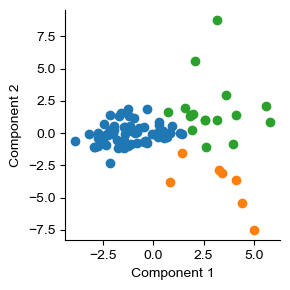

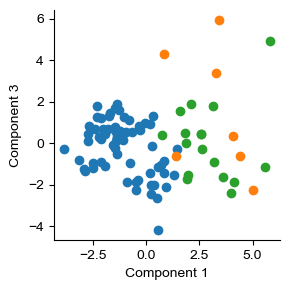

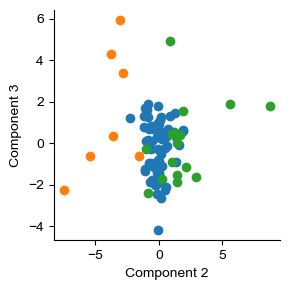

In [301]:
dt = pca_pipeline.fit_transform(cluster_data_e)
for dim1, dim2, to_save in [
    (0, 1, "PCA_dim1_2"), (0, 2, "PCA_dim1_3"), (1, 2, "PCA_dim2_3")
]:
    analysor.plot_decomposition_scatter(
        dt, km_clusters, dim1, dim2, show_legend=False
    )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


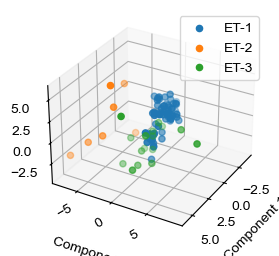

In [302]:
analysor.plot_decomposition_scatter(
    dt, km_clusters,
    to_save="PCA_dim123",
    plot_3d=True,
    fig_size=(3,3),
    label_map={0: "ET-1", 1: "ET-2", 2: "ET-3"},
)

### PCA scatter plot

In [ ]:
pca_dat = analysor.k_means(
    cluster_data_e, n_cluster=3, return_filled=True, random_state=15, return_scaled=True,
    label_mapping={0: 1, 1: 0, 2: 2}
)
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat, to_save="PCA_dim1_2", show_legend=False
)

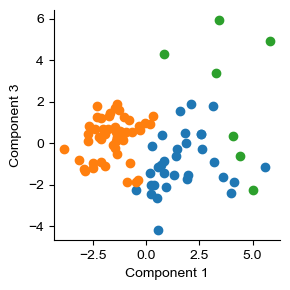

In [112]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat, dim2=2, to_save="PCA_dim1_3", show_legend=False
)

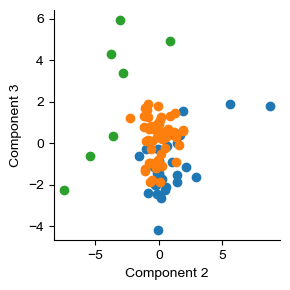

In [113]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat, dim1=1, dim2=2, to_save="PCA_dim2_3", show_legend=False
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


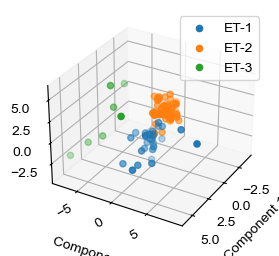

In [114]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat,
    to_save="PCA_dim123",
    plot_3d=True,
    fig_size=(3,3),
    label_map={0: "ET-1", 1: "ET-2", 2: "ET-3"},
)

### Inter-class comparation

In [55]:
inter_class_stat_e = analysor.stat_analyse(
    km_e.drop(columns="cellID_ap"),
    #     test_small_sample=True,
    group1=0,
    group2=1,
)
inter_class_stat_e

,variable,stat_method,p_value
0,Rm,Wilcoxon rank-sum test,6.972587e-08
1,RMP,t_test,2.920442e-05
2,tau,Wilcoxon rank-sum test,6.265452e-03
3,n,Wilcoxon rank-sum test,7.353087e-02
4,Freq (Hz),Wilcoxon rank-sum test,3.623914e-03
5,CV_of_IF,Wilcoxon rank-sum test,6.250781e-01
6,AP1_amp,t_test,6.614326e-01
7,AP2_amp,t_test,2.620755e-01
8,APlast_amp,t_test,1.194697e-02
9,ISI_log_slope,Wilcoxon rank-sum test,6.092622e-03


Which parameter show significant:

In [56]:
inter_class_stat_e[inter_class_stat_e.p_value < 0.05].variable.to_list()

['Rm',
 'RMP',
 'tau',
 'Freq (Hz)',
 'APlast_amp',
 'ISI_log_slope',
 'ISI_semilog_slope',
 'inv_first_ISI',
 'inv_last_ISI',
 'inv_second_ISI',
 'inv_third_ISI',
 'inv_time_to_first_spike',
 'mean_AHP_depth_abs',
 'mean_AHP_depth_abs_slow',
 'mean_AHP_time_from_peak',
 'number_initial_spikes',
 'steady_state_voltage_stimend',
 'time_to_last_spike',
 'threshold_V',
 'ramp_spiking_time']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


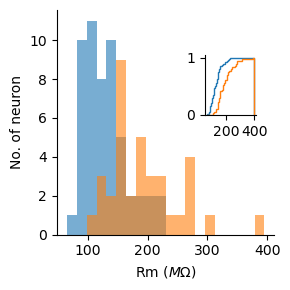

In [57]:
from neuron_cluster_analysis import plot_cluster_hist

plot_cluster_hist(
    km_e,
    "Rm",
    xlabel="Rm " + "$(M\Omega)$",
    group1=0,
    group2=1,
    to_save="Rm_clusters",
    plot_cumulative=True,
    #     legend_kw={"loc": 4}
    show_legend=False,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


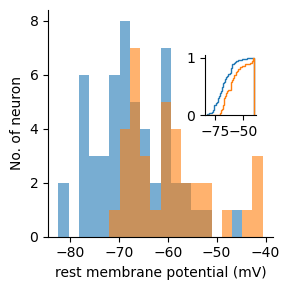

In [58]:
plot_cluster_hist(
    km_e,
    "RMP",
    xlabel="rest membrane potential (mV)",
    group1=0,
    group2=1,
    plot_cumulative=True,
    to_save="RMP_clusters",
    #     legend_kw={"loc": 5},
    show_legend=False,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


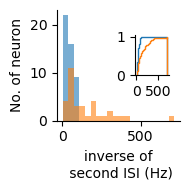

In [59]:
plot_cluster_hist(
    km_e,
    "inv_second_ISI",
    xlabel="inverse of\n second ISI (Hz)",
    group1=0,
    group2=1,
    plot_cumulative=True,
    #     legend_kw={"loc": 5}
    show_legend=False,
    fig_size=(2, 2),
    to_save="inv_second_ISI_hist",
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


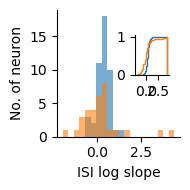

In [60]:
plot_cluster_hist(
    km_e,
    "ISI_log_slope",
    xlabel="ISI log slope",
    #     group1=0, group2=2,
    plot_cumulative=True,
    #     legend_kw={"loc": 4},
    show_legend=False,
    fig_size=(2, 2),
    to_save="ISI_log_slope",
)

In [61]:
clust1_id = km_e[km_e.cluster == 0].cellID_ap.values
clust2_id = km_e[km_e.cluster == 1].cellID_ap.values

In [ ]:
from neuron_cluster_analysis import select_demo_cell_id

# id_select = select_demo_cell_id(km_e, "inv_first_ISI")
for i in range(km_e.shape[0]):
    id_select = km_e.iloc[i]["cellID_ap"]
    analysor.plot_demo_ap(
        sweep=13, 
        cell_id=id_select, 
        # cell_id=id_select[0], 
        to_save=f"demos/demo_ET1_ap_{i}", fig_size=(3, 1.5)
    )

In [ ]:
for i in range(km_e.shape[0]):
    id_select = km_e.iloc[i]["cellID_ap"]
    try:
        analysor.plot_demo_ap(
            sweep=13,
            cell_id=id_select,
            # cell_id=id_select[1],
            to_save=f"demos2/demo_ET2_ap_{i}",
            # to_save="demo_ET2_ap",
            sweepYcolor="C1",
            sweepCcolor="C1",
            fig_size=(3, 1.5),
        )
    except:
        print(f"{id_select} sweep 14 not found")

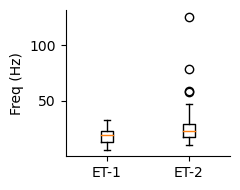

In [64]:
from neuron_cluster_analysis import plot_cluster_stat

plot_cluster_stat(
    km_e,
    "Freq (Hz)",
    plot_box=True,
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    ylabel="Freq (Hz)",
    to_save="Freq_clusters",
)

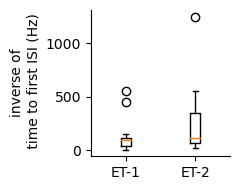

In [65]:
plot_cluster_stat(
    km_e,
    "inv_first_ISI",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="inverse of\n time to first ISI (Hz)",
    to_save="inv_first_ISI_clusters",
)

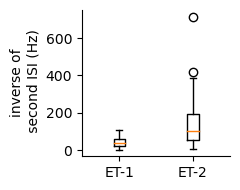

In [66]:
plot_cluster_stat(
    km_e,
    "inv_second_ISI",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="inverse of\n second ISI (Hz)",
    to_save="inv_second_ISI_clusters",
)

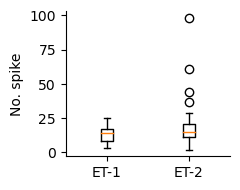

In [67]:
plot_cluster_stat(
    km_e,
    "n",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="No. spike",
    to_save="spike_n_clusters",
)

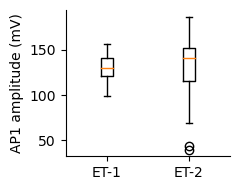

In [68]:
plot_cluster_stat(
    km_e,
    "AP1_amp",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="AP1 amplitude (mV)",
    to_save="AP1_amp_clusters",
)

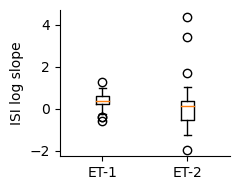

In [69]:
plot_cluster_stat(
    km_e,
    "ISI_log_slope",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="ISI log slope",
    to_save="ISI_log_slope_clusters",
)

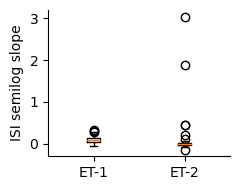

In [70]:
plot_cluster_stat(
    km_e,
    "ISI_semilog_slope",
    plot_box=True,
    xticks=["ET-1", "ET-2"],
    ylabel="ISI semilog slope",
    to_save="ISI_semilog_slope_clusters",
)

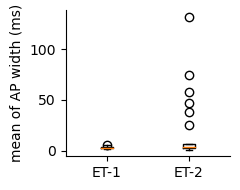

In [71]:
plot_cluster_stat(
    km_e,
    "mean_AP_width",
    xticks=["ET-1", "ET-2"],
    ylabel="mean of AP width (ms)",
    to_save="mean_AP_width_clusters",
    plot_box=True
)

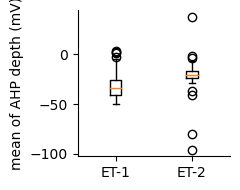

In [72]:
plot_cluster_stat(
    km_e,
    "mean_AHP_depth_abs",
    xticks=["ET-1", "ET-2"],
    ylabel="mean of AHP depth (mV)",
    to_save="mean_AHP_depth_abs_clusters",
    plot_box=True,
)

Plot ramp current of cluster 1

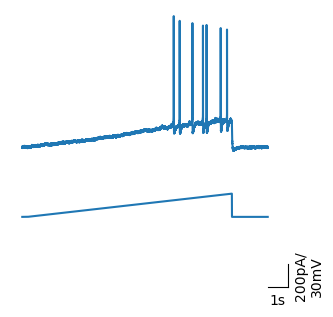

In [73]:
to_plot_id = cluster_data_e[cluster_data_e.cellID_ap==clust1_id[-2]].cellID_ramp.values[0]
analysor.elec_ps.plot_demo_ramp(cell_id=to_plot_id, sweep=2, to_save="demo_ET1_ramp")

In [ ]:
for i, cell_id in enumerate(cluster_data_e["cellID_ramp"].unique()):
    try:
        analysor.elec_ps.plot_demo_ramp(
            cell_id=cell_id, sweep=2, to_save=f"demo3/demo_ET1_ramp_{i}"
        )
    except:
        print(f"{cell_id} failed")

Plot ramp current of cluster 2

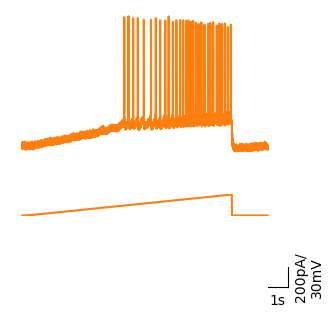

In [74]:
to_plot_id = cluster_data_e[
    cluster_data_e.cellID_ap==clust2_id[-2]
].cellID_ramp.values[0]
analysor.elec_ps.plot_demo_ramp(
    cell_id=to_plot_id,
    sweep=2,
    to_save="demo_ET2_ramp",
    sweepYcolor="C1",
    sweepCcolor="C1",
)

In [ ]:
for i, cell_id in enumerate(cluster_data_e["cellID_ramp"].unique()):
    try:
        analysor.elec_ps.plot_demo_ramp(
            cell_id=cell_id, sweep=2, to_save=f"demo4/demo_ET1_ramp_{i}",
            sweepYcolor="C1", sweepCcolor="C1"
        )
    except:
        print(f"{cell_id} failed")

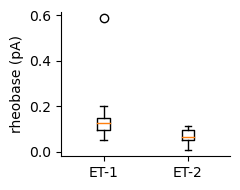

In [75]:
plot_cluster_stat(
    km_e,
    "threshold_I",
    xticks=["ET-1", "ET-2"],
    ylabel="rheobase (pA)",
    to_save="rheobase_clusters",
    plot_box=True,
)

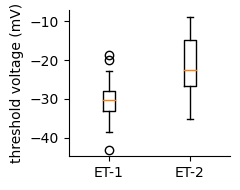

In [76]:
plot_cluster_stat(
    km_e,
    "threshold_V",
    xticks=["ET-1", "ET-2"],
    ylabel="threshold voltage (mV)",
    to_save="threshold_V_clusters",
    plot_box=True,
)

### Morphological classifier

Prepare morphology dataset for SVM training:

In [77]:
from neuron_cluster_analysis import k_means_preprocess

train_dat = analysor.get_morpho_cluster_label(km_e, cluster_data)
morpho_train = train_dat.set_index("cluster")["reconstruction_ID"]
train_dat = k_means_preprocess(train_dat).drop(columns="cellID_ap")
train_dat = train_dat.fillna(train_dat.mean())
train_dat.head()

,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,Filament No. Dendrite Segments,...,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal),cluster
0,10910.00,10910.00,4083.05,2821.49,305.977,8.0,6.0,4083.05,26.0,57.0,...,4.0,57.0,10687.0,4081.369858,2834.939976,1246.429882,2821.164532,2287.254572,533.909960,1
1,11333.90,11333.90,4358.37,3911.53,342.625,13.0,6.0,4358.37,46.0,96.0,...,4.0,96.0,10620.0,4357.301262,3468.067425,889.233837,3910.565760,3719.070310,191.495450,0
2,6855.76,6855.76,2014.88,2291.71,446.037,7.0,3.0,2014.88,7.0,20.0,...,6.0,20.0,2518.0,2007.632324,1376.187553,631.444771,2290.291278,1962.327718,327.963560,0
3,7529.28,7529.28,2988.55,1775.40,425.158,9.0,5.0,2988.55,28.0,61.0,...,6.0,60.0,11625.0,2987.019941,2070.660289,916.359652,1775.096559,1357.492065,417.604493,0
4,6091.93,6091.93,2058.37,1589.63,327.495,9.0,3.0,2058.37,18.0,39.0,...,5.0,37.0,2040.0,2053.981322,1499.087242,554.894080,1588.768071,1214.119188,374.648883,0


In [78]:
svm_f = analysor.svm_train(train_dat)
y_test = svm_f(train_dat.drop(columns="cluster"))
correct = y_test == train_dat.cluster.values
print("Correct prediction rate: {}".format(correct.sum() / correct.size))

Correct prediction rate: 1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


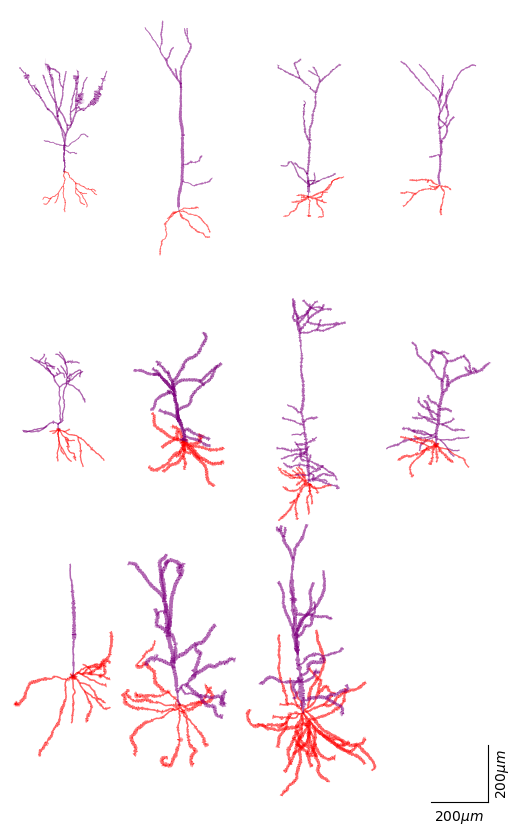

In [79]:
train_c1 = [n for n in mpp.neurons if n.name.replace(".swc", "") in morpho_train[0].values]
mpp.plot_apical_upside(train_c1, to_save="train_ET1")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


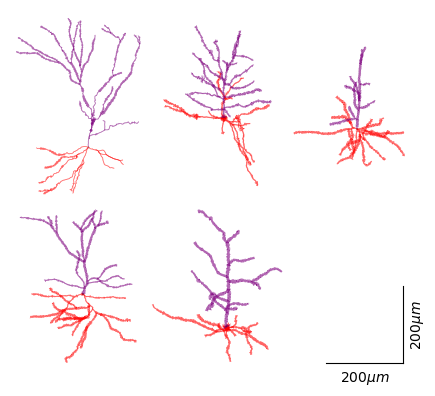

In [80]:
train_c2 = [n for n in mpp.neurons if n.name.replace(".swc", "") in morpho_train[1].values]
mpp.plot_apical_upside(train_c2, to_save="train_ET2")

### predict new morphology

#### GFP+ neurons

In [81]:
pred_mpp = morpho_parser(
    {
        "swc": "../../../reconstruction/predict/traces/GFP+_repair",
        "imaris": "../../../reconstruction/predict/stat/GFP+",
    }
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


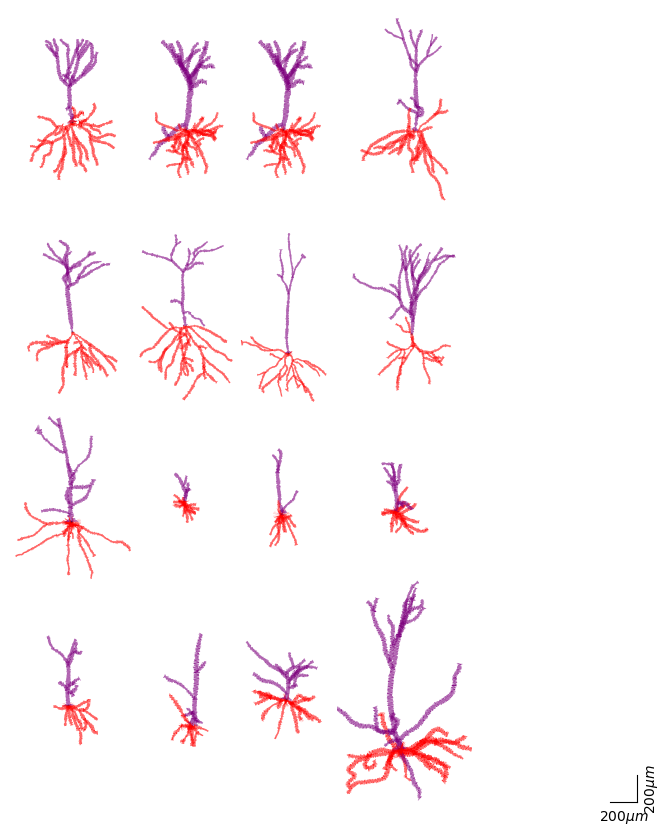

In [82]:
to_plot_neurons = list(pred_mpp.neurons)
to_plot_neurons = to_plot_neurons[1:] + [to_plot_neurons[0]]
pred_mpp.plot_apical_upside(to_plot_neurons,to_save="GFP+ neurons")

In [83]:
gfp_morpho_dat = pred_mpp.get_all_data()  # time consuming
gfp_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_leaves,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal)
0,(GFP+)slice_1_red neuron1,109792.0,109792.0,12526.60,87549.1,1001.64,11.0,5.0,12526.60,26.0,...,31.0,6.0,55.0,11179.0,12523.332747,6243.109705,6280.223042,87094.183042,40332.193348,46761.989695
1,GFP+ slice_1 20180615 neuron1,50247.0,50247.0,7899.42,27785.5,1246.49,9.0,5.0,7899.42,33.0,...,37.0,5.0,69.0,3964.0,7888.850036,3082.590848,4806.259188,27388.566912,12131.473835,15257.093077
2,GFP+ slice_3 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,53.0,...,57.0,4.0,109.0,7710.0,8770.851685,3543.358332,5227.493354,36553.847035,22856.368857,13697.478178
3,GFP+ slice_4 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,54.0,...,57.0,4.0,109.0,7710.0,8770.851685,3543.358332,5227.493354,36553.847035,22856.368857,13697.478178
4,GFP+ slice_5 20180627 neuron1,43277.8,43277.8,7343.18,21937.4,1196.57,9.0,6.0,7343.18,41.0,...,44.0,3.0,85.0,6269.0,7336.498842,2657.714449,4678.784393,21884.661855,7481.010438,14403.651417


In [84]:
gfp_cluster = svm_f(gfp_morpho_dat)
gfp_morpho_dat["cluster"] = gfp_cluster
gfp_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal),cluster
0,(GFP+)slice_1_red neuron1,109792.0,109792.0,12526.60,87549.1,1001.64,11.0,5.0,12526.60,26.0,...,6.0,55.0,11179.0,12523.332747,6243.109705,6280.223042,87094.183042,40332.193348,46761.989695,0
1,GFP+ slice_1 20180615 neuron1,50247.0,50247.0,7899.42,27785.5,1246.49,9.0,5.0,7899.42,33.0,...,5.0,69.0,3964.0,7888.850036,3082.590848,4806.259188,27388.566912,12131.473835,15257.093077,0
2,GFP+ slice_3 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,53.0,...,4.0,109.0,7710.0,8770.851685,3543.358332,5227.493354,36553.847035,22856.368857,13697.478178,0
3,GFP+ slice_4 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,54.0,...,4.0,109.0,7710.0,8770.851685,3543.358332,5227.493354,36553.847035,22856.368857,13697.478178,0
4,GFP+ slice_5 20180627 neuron1,43277.8,43277.8,7343.18,21937.4,1196.57,9.0,6.0,7343.18,41.0,...,3.0,85.0,6269.0,7336.498842,2657.714449,4678.784393,21884.661855,7481.010438,14403.651417,0


In [85]:
gfp_morpho_inter = analysor.stat_analyse(
    gfp_morpho_dat.drop(columns="reconstruction_ID"),
    group1=0,
    group2=1,
    test_small_sample=True,
)
gfp_morpho_inter[gfp_morpho_inter.p_value < 0.05].variable

0                             Filament Area (sum)
1                    Filament Dendrite Area (sum)
2                  Filament Dendrite Length (sum)
3                  Filament Dendrite Volume (sum)
4                   Filament Distance from Origin
5                      Filament Full Branch Depth
7                           Filament Length (sum)
11                          Filament Volume (sum)
13                    max_sholl_intercept(apical)
15                      max_sholl_intercept_radii
16              max_sholl_intercept_radii(apical)
17               max_sholl_intercept_radii(basal)
22                   mean_neurite_lengths(apical)
27                           mean_neurite_volumes
28                   mean_neurite_volumes(apical)
31    mean_number_of_sections_per_neurite(apical)
33               mean_principal_direction_extents
34       mean_principal_direction_extents(apical)
35        mean_principal_direction_extents(basal)
37         mean_remote_bifurcation_angles(apical)


In [86]:
gfp_c1_neurons = [
    n
    for n in pred_mpp.neurons.morphologies
    if n.name.replace(".swc", "") in gfp_morpho_dat[gfp_morpho_dat.cluster == 0].reconstruction_ID.values
]
gfp_c2_neurons = [
    n
    for n in pred_mpp.neurons.morphologies
    if n.name.replace(".swc", "") in gfp_morpho_dat[gfp_morpho_dat.cluster == 1].reconstruction_ID.values
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


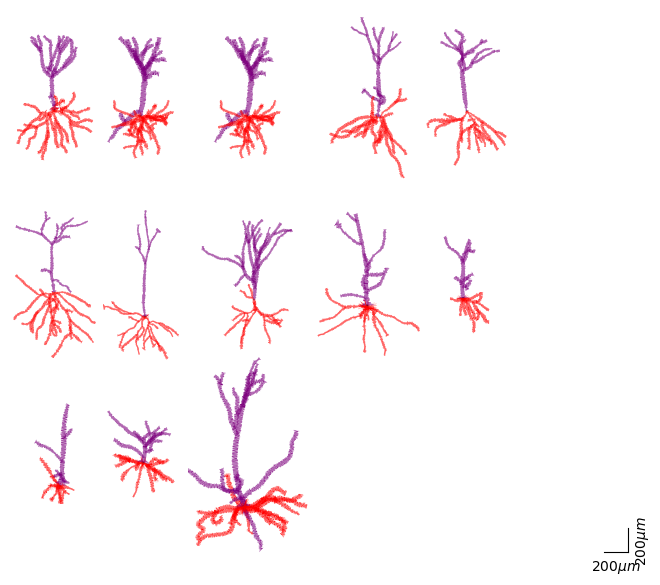

In [87]:
to_plot_neurons = list(gfp_c1_neurons[1:])+[gfp_c1_neurons[0]]
pred_mpp.plot_apical_upside(to_plot_neurons, to_save="GFP+ ET1", fig_size=(7.5, 5.5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


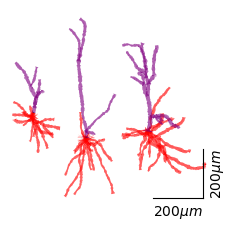

In [88]:
mpp.plot_apical_upside(gfp_c2_neurons, to_save="GFP+ ET-2")

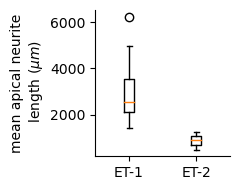

In [89]:
plot_cluster_stat(
    gfp_morpho_dat,
    "mean_neurite_lengths(apical)",
    ylabel="mean apical neurite\n length (" + "$\mu m)$",
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    plot_box=True,
    to_save="mean_neurite_lengths(apical)_gfp_clusters",
)

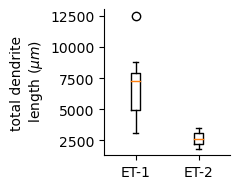

In [90]:
plot_cluster_stat(
    gfp_morpho_dat,
    "Filament Dendrite Length (sum)",
    ylabel="total dendrite\n length (" + "$\mu m)$",
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    plot_box=True,
    to_save="dendrite_lengths_gfp_clusters",
)

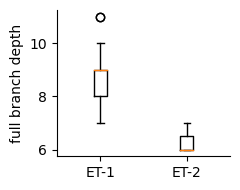

In [91]:
plot_cluster_stat(
    gfp_morpho_dat,
    "Filament Full Branch Depth",
    ylabel="full branch depth",
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    plot_box=True,
    to_save="branch_depth_gfp_clusters",
)

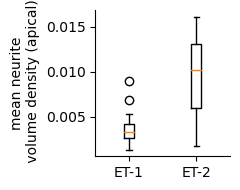

In [92]:
plot_cluster_stat(
    gfp_morpho_dat,
    "mean_neurite_volume_density(apical)",
    ylabel="mean neurite\n volume density (apical)",
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    plot_box=True,
    to_save="mean_neurite_volume_density(apical)_gfp_clusters",
)

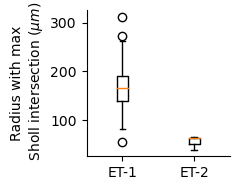

In [93]:
plot_cluster_stat(
    gfp_morpho_dat,
    "max_sholl_intercept_radii",
    ylabel="Radius with max\n Sholl intersection " + "$(\mu m)$",
    clusters=(0, 1),
    xticks=["ET-1", "ET-2"],
    plot_box=True,
    to_save="max_sholl_intercept_radii_gfp_clusters",
)

Sholl intersection of two clusters:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


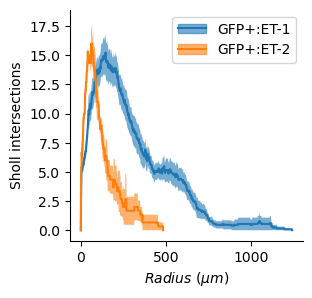

In [94]:
from neuron_cluster_analysis import plot_cluster_sholl

plot_cluster_sholl(
    pred_mpp,
    [c.name for c in gfp_c1_neurons],
    [c.name for c in gfp_c2_neurons],
    clusters=(0, 1),
    sholl_part=False,
    label_map={0: "GFP+:ET-1", 1: "GFP+:ET-2"},
    to_save="GFP+ c1_c2 sholl",
)

#### GFP- neurons

In [95]:
pred_mpp2 = morpho_parser(
    {
        "swc": "../../../reconstruction/predict/traces/GFP-_repair",
        "imaris": "../../../reconstruction/predict/stat/GFP-",
    }
)

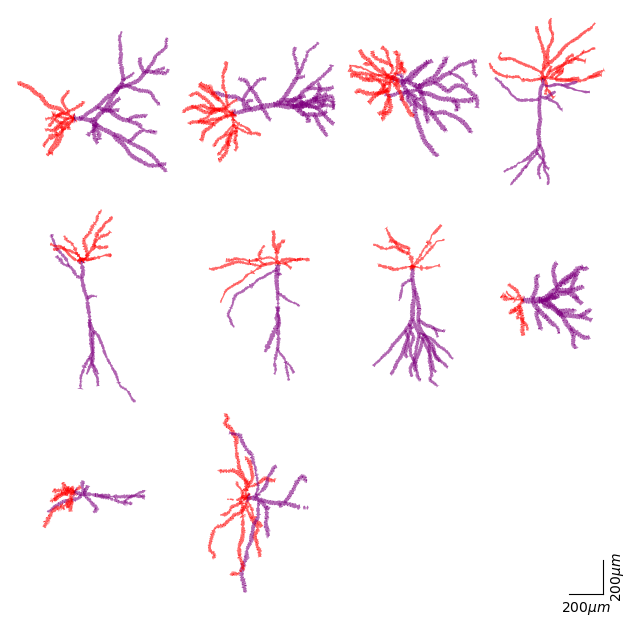

In [96]:
pred_mpp2.plot_all_neurons()

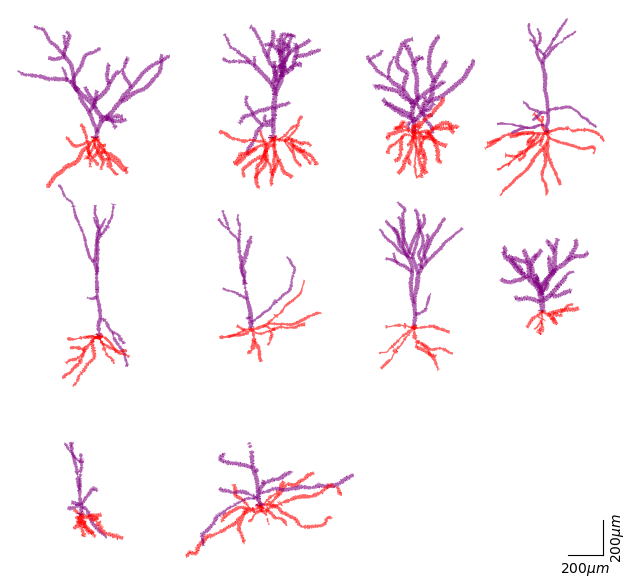

In [97]:
pred_mpp2.plot_apical_upside()

In [98]:
control_morpho_dat = pred_mpp2.get_all_data()  # time consuming
control_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_leaves,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal)
0,(GFP+ near)slice_2_red neuron1,51411.8,51411.8,6574.97,34508.5,1018.01,9.0,4.0,6574.97,31.0,...,35.0,3.0,66.0,5800.0,6573.042528,4327.419461,2245.623067,34423.084141,24407.147533,10015.936608
1,(GFP+ near)slice_3_red neuron1,65068.2,65068.2,8483.36,43246.5,1168.61,11.0,5.0,8483.36,41.0,...,45.0,3.0,85.0,7677.0,8480.581436,4765.806776,3714.774661,43162.440787,28041.759595,15120.681192
2,(GFP+ near)slice_4_red neuron1,63466.5,63466.5,7652.02,44932.2,1016.16,10.0,4.0,7652.02,40.0,...,44.0,3.0,84.0,6874.0,7651.551350,4192.124296,3459.427053,44924.907581,28079.690024,16845.217557
3,GFP- slice_1 20180627 neuron1,35223.3,35223.3,5702.38,18943.9,1223.70,9.0,4.0,5702.38,26.0,...,29.0,3.0,55.0,2681.0,5695.486552,2369.160878,3326.325673,18694.891144,7344.898335,11349.992809
4,GFP- slice_2 20180627 neuron1,25122.2,25122.2,4130.41,13715.6,1167.10,6.0,3.0,4130.41,13.0,...,18.0,6.0,30.0,2643.0,4120.026361,2361.286466,1758.739895,13487.063878,7676.321257,5810.742621


In [99]:
control_cluster = svm_f(control_morpho_dat)
control_morpho_dat["cluster"] = control_cluster
control_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_neurites,number_of_sections,number_of_segments,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),total_volume_per_neurite,total_volume_per_neurite(apical),total_volume_per_neurite(basal),cluster
0,(GFP+ near)slice_2_red neuron1,51411.8,51411.8,6574.97,34508.5,1018.01,9.0,4.0,6574.97,31.0,...,3.0,66.0,5800.0,6573.042528,4327.419461,2245.623067,34423.084141,24407.147533,10015.936608,0
1,(GFP+ near)slice_3_red neuron1,65068.2,65068.2,8483.36,43246.5,1168.61,11.0,5.0,8483.36,41.0,...,3.0,85.0,7677.0,8480.581436,4765.806776,3714.774661,43162.440787,28041.759595,15120.681192,1
2,(GFP+ near)slice_4_red neuron1,63466.5,63466.5,7652.02,44932.2,1016.16,10.0,4.0,7652.02,40.0,...,3.0,84.0,6874.0,7651.551350,4192.124296,3459.427053,44924.907581,28079.690024,16845.217557,0
3,GFP- slice_1 20180627 neuron1,35223.3,35223.3,5702.38,18943.9,1223.70,9.0,4.0,5702.38,26.0,...,3.0,55.0,2681.0,5695.486552,2369.160878,3326.325673,18694.891144,7344.898335,11349.992809,0
4,GFP- slice_2 20180627 neuron1,25122.2,25122.2,4130.41,13715.6,1167.10,6.0,3.0,4130.41,13.0,...,6.0,30.0,2643.0,4120.026361,2361.286466,1758.739895,13487.063878,7676.321257,5810.742621,0


In [100]:
control_c1_neurons = [
    n
    for n in pred_mpp2.neurons.morphologies
    if n.name.replace(".swc", "")
    in control_morpho_dat[control_morpho_dat.cluster == 0].reconstruction_ID.values
]
control_c2_neurons = [
    n
    for n in pred_mpp2.neurons.morphologies
    if n.name.replace(".swc", "")
    in control_morpho_dat[control_morpho_dat.cluster == 1].reconstruction_ID.values
]

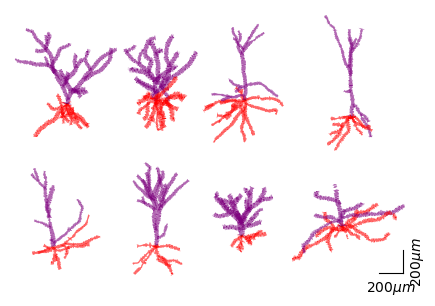

In [101]:
pred_mpp2.plot_apical_upside(control_c1_neurons)

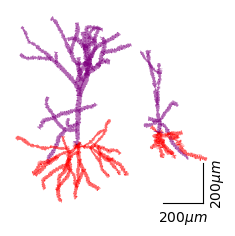

In [102]:
pred_mpp2.plot_apical_upside(control_c2_neurons)